# Budget Bus Numbers

## About

This is a spin-off script from the original Bus Numbers script that is used to extract bus numbers from buses in images and write the information into an audio file to be played.

Because Azure is expensive, here is a script where everything involved is "free" to use.

## Dependencies
Use <pre>pip3 install -r requirements.txt</pre> to install python 3 dependencies

Note that ImageMagick and Docker must be installed to use this

### Script Overview
1. Find bounding box of bus numbers with offline docker container
2. Crop image to bounding box location
3. OCR on cropped image
4. Extract result and write to audio file

bus_ext_1.jpeg	bus_ext_4.jpg  bus_ext_7.jpg	   bus_int_1.jpg
bus_ext_2.jpg	bus_ext_5.jpg  bus_ext_8.jpeg	   non_bus_1.jpg
bus_ext_3.jpg	bus_ext_6.jpg  bus_high_res_1.jpg  readme.txt


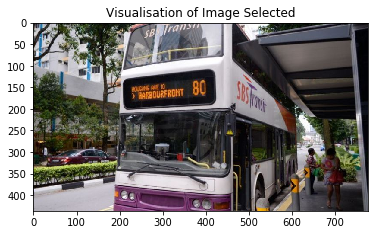

In [1]:
# Libaries
import requests
import json
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from os import getenv, stat
from pprint import pprint
from gtts import gTTS
import IPython.display as ipd

# List Image Files to Choose From
!ls test_img

# Select Test Image
test_image = "test_img/bus_ext_7.jpg"

# Opening the File
image = Image.open(test_image)
plt.title("Visualisation of Image Selected")
imshow(image)

## Use Azure Custom Vision to Find Bounding Box of Image

In [2]:
## Ensure that the Image is of the Acceptable Size
while stat(test_image).st_size > 4100000:
    image = Image.open(test_image)
    x = int(image.size[0]*0.9)
    y = int(image.size[1]*0.9)
    image = image.resize((x,y), Image.ANTIALIAS)
    test_image = "/tmp/resized.jpg"
    image.save(test_image)
    print("Lowered Size of Image by 19%")

In [3]:
# Use the Custom Vision Docker File (Superior Speed and Cost)
# NOTE: Change the following docker folder if you are using a different docker folder name
! ./custom_vision_docker/run_docker.sh
with open(test_image, 'rb') as image_file:
    custom_vision_response = requests.post("http://127.0.0.1/image", data=image_file, headers={"Content-Type": "application/octet-stream"} )
! docker container kill $(docker ps -q)

Sending build context to Docker daemon  44.15MB
Step 1/7 : FROM python:3.7-slim
 ---> 7e61acc68112
Step 2/7 : RUN pip install -U pip
 ---> Using cache
 ---> ed994d7b27c2
Step 3/7 : RUN pip install numpy==1.17.3 tensorflow==2.0.0 flask pillow
 ---> Using cache
 ---> f84d0c46a18e
Step 4/7 : COPY app /app
 ---> Using cache
 ---> 47caccaa16b5
Step 5/7 : EXPOSE 80
 ---> Using cache
 ---> 3198c545eb01
Step 6/7 : WORKDIR /app
 ---> Using cache
 ---> 0c27347180b1
Step 7/7 : CMD python -u app.py
 ---> Using cache
 ---> f83e4aafaffa
Successfully built f83e4aafaffa
Successfully tagged custom_vision:latest
dc64eae51d67209c80c71f301e38b873b50ce8aba0eedad04b571d1805d4664a
dc64eae51d67


In [4]:
json_response= json.loads(custom_vision_response.text)
bounding_boxes = json_response['predictions']
threshold = 0.2 #Threshold on what probability corresponds to a valid bounding box

# Extract Best Bounding Box with Probability > threshold
max_probability = -1 
for bounding_box in bounding_boxes:
    #print("Box:", bounding_box['probability'])
    max_probability = max(max_probability, bounding_box['probability'])

if max_probability < threshold:
    print("No Valid Bounding Boxes Found")
    raise Exception("No Bounding Boxes")
for i in bounding_boxes:
    if i['probability'] == max_probability:
        bounding_box = i 
        print(bounding_box)

{'boundingBox': {'height': 0.18568582, 'left': 0.28467508, 'top': 0.26762648, 'width': 0.27474664}, 'probability': 0.7642777, 'tagId': 0, 'tagName': 'bus_number'}


In [5]:
bounding_box = bounding_box['boundingBox']
print("Bounding Box:", bounding_box)

Bounding Box: {'height': 0.18568582, 'left': 0.28467508, 'top': 0.26762648, 'width': 0.27474664}


## Use Python Image Libary to Crop Image at Bounding Box

[]

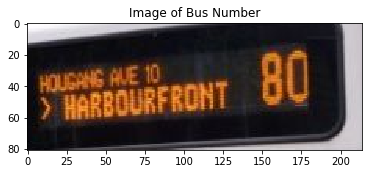

In [6]:
# Import Test Image into Python
raw_image = Image.open(test_image)
width, height = raw_image.size

# Set Points for Cropped Image to Bounding Box
left = width*bounding_box['left']
right = left + width*bounding_box['width']
top = height*bounding_box['top']
bottom = top + height*bounding_box['height']

# Crop Image
bus_num_image = raw_image.crop((left, top, right, bottom))
plt.title("Image of Bus Number")
imshow(np.asarray(bus_num_image)) #Display the Image
plt.plot()

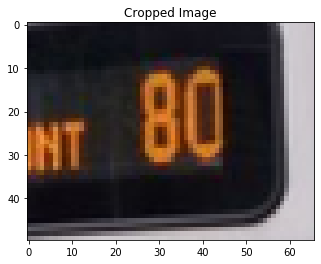

In [7]:
ocr_crop_percentage = 0.5
# Crop Away ocr_crop_percentage of Left Side for OCR Reasons
width, height = bus_num_image.size
left = width * ocr_crop_percentage
right = width
top = 0
bottom = height

ocr_image = bus_num_image.crop((left, top, right, bottom))

# Resize Image with Interpolation if height too big (somehow OCR on Azure doesn't work too well with too sharp of bus numbers)
width, height = ocr_image.size
if height > 50:
    ocr_image = ocr_image.resize((int(width*50/height),50),Image.ANTIALIAS) # Ensure the aspect ratio doesn't change
plt.title("Cropped Image")
imshow(np.asarray(ocr_image)) #Display the Image

# Save OCR Ready Image
ocr_image_file = "ocr.png"
ocr_image.save(ocr_image_file)

## Improve Image Quality with Image Magick

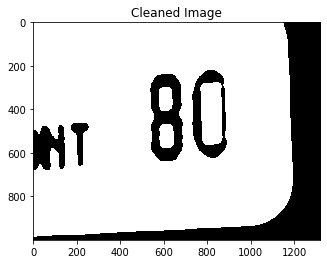

In [8]:
# Call image magick
# Ensure that convert is in your PATH
! convert ocr.png -resize 2000% -colorspace gray +dither -type bilevel -negate resized.png

converted_image = Image.open("resized.png")
plt.title("Cleaned Image")
plt.imshow(converted_image)
plt.show()

## Send Image to OCR API

In [9]:
# Define Functions to Send Image to OCR Space API 
# Please don't steal the API key, it's fine to use here but don't use it for other things (just get another)
def ocr_space_file(filename, overlay=False, api_key='5fbfe9786f88957', language='eng'):
    payload = {'isOverlayRequired': overlay,
               'apikey': api_key,
               'language': language,
               'OCREngine': 2
               }
    with open(filename, 'rb') as f:
        r = requests.post('https://api.ocr.space/parse/image',
                          files={filename: f},
                          data=payload,
                          )
    return r.content.decode()


def parse_image(img_name):
    response = ocr_space_file(img_name)
    result = json.loads(response)
    pprint(result)
    text = result["ParsedResults"][0]["ParsedText"]
    text = text.split("\n")[0]
    return text

In [10]:
# Call the API and Extract Bus Number
try:
    bus_number = parse_image("resized.png")
except Exception as e:
    print(e)
    bus_number = ""
    
done = False
if bus_number != "":
    print("Number Detected:", bus_number)
    done = True
else:
    bus_number = parse_image("ocr.png")

if bus_number != "" and not done:
    print("Number Detected 2:", bus_number)
elif not done:
    print("Cant Read Number on Bus")
    raise Exception("Couldnt Read Bus Number")

{'IsErroredOnProcessing': False,
 'OCRExitCode': 1,
 'ParsedResults': [{'ErrorDetails': '',
                    'ErrorMessage': '',
                    'FileParseExitCode': 1,
                    'ParsedText': '80',
                    'TextOrientation': '0',
                    'TextOverlay': {'HasOverlay': True,
                                    'Lines': [],
                                    'Message': 'Total lines: 0'}}],
 'ProcessingTimeInMilliseconds': '671',
 'SearchablePDFURL': ''}
Number Detected: 80


## Write to Audio File

In [11]:
# Prepare Audio File
audio_text = "Bus " + bus_number + " is coming now!"
language = 'en'
audio_obj = gTTS(text=audio_text, lang=language, slow=False) 
audio_obj.save("bus_number.wav") 

# Display Option to Play File in Notebook
ipd.Audio('bus_number.wav')